# Resting state connectivity pattern extraction 

## Importing required packages

In [2]:
import os
# import syspar
import pickle

import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pylab as plt 

from time import sleep
from scipy import signal
from scipy import mean
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.io import loadmat, savemat
from scipy.stats import zscore, ttest_rel
from scipy.stats import t as int_pckg
from statsmodels.stats.multitest import fdrcorrection

## Setting directories

In [3]:
# Set the directory of the unzipped data here: 
data_dir = '/Users/nicobruno/Downloads/mind_blanking-master/'

# Set the directory that results should be saved: 
save_dir = '/Users/nicobruno/Downloads/mind_blanking-master/'
if os.path.exists(os.path.join(save_dir, 'Results/Conn_Analysis/'))==0:
    os.makedirs(os.path.join(save_dir, 'Results/Conn_Analysis/'))

# Other required directories are set automatically here: 
res_dir = os.path.join(save_dir, 'Results/Conn_Analysis/')
log_dir = os.path.join(data_dir, 'MB_Dataset/Triggers/')
img_dir = os.path.join(data_dir, 'MB_Dataset/Neuroimaging')
kmeans_dir = os.path.join(data_dir, 'MB_Dataset/KMeans_Model/')

## Setting required variables and defining required functions

In [4]:
subjects = [
    's8177', 's8178', 's8189', 's8190', 's8191', 's8193', 's8194',
    's8195', 's8211', 's8220', 's8221', 's8244', 's8268', 's8296', 
    's8313', 's8314', 's8355', 's8356', 's8363', 's8367', 's8412',
    's8436', 's8437', 's8458', 's8459', 's8500', 's8550', 's8680',
    's8681', 's8726', 's8727', 's8739', 's8760', 's8761', 's8776',
    's8800'
]


def adif(phi1, phi2):
    ## Performs phase wrapping 
    import numpy as np
    if abs(phi2-phi1)>np.pi:
        return 2*np.pi-abs(phi2-phi1)
    else:
        return abs(phi2-phi1)
    
def bp_filter(sig, fmin, fmax, TR, order): 
    ## bandpass filtering of BOLD signal 
    from scipy import signal
    fnyq = 1/(2*TR)  
    wn = np.array([fmin/fnyq, fmax/fnyq]) 
    [b, a] = signal.butter(order, wn, btype='band')
    return signal.lfilter(b, a, sig, axis=1)

def ci(data):
    ## Calculating 95% confidence interval of mean estimation 
    from scipy.stats import sem, t
    from scipy import mean
    confidence = 0.95
    n = np.shape(data)[0]
    m = np.nanmean(data, axis=0)
    std_err = sem(data, axis=0, nan_policy='omit')
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    start = m - h
    end = m + h
    return (start, end)

## Phase-based coherency analysis for connectivity pattern estimation of each time point  

In [22]:
R = 100 # Numebr of Regions 
do_filter = 1 # whether perform BPF before hilbert transform or not 
gs = 0 # whether to use Normal (0), GSS (1), or GSR (2) version of the data 

idx = np.where(np.tril(np.ones((R, R)), k=-1)) # Indices of the lower triangle of connectivity matrices 
Patterns = np.zeros((int(R*(R-1)/2), 1)) # Variable to store connectivity patterns of all time points 

c=0 # Subject Counter 

subj_pointer = []
seg_pointer = []
rest_idx = []
rep_pointer = np.array([0]).reshape((1,1))

for sub in subjects: 
    sys.stdout.write('\r')
    sys.stdout.write("[{:{}}] {:.1f}%".format("="*c, len(subjects)-1, (100/(len(subjects)-1)*c)))
    
    if gs==2:
        sig_dir = img_dir + '/' + sub + '/Sig_file_' + sub + '_GSR.txt'
    elif gs==1:
        sig_dir = img_dir + '/' + sub + '/Sig_file_' + sub + '_GSS.txt'
    else: 
        sig_dir = img_dir + '/' + sub + '/Sig_file_' + sub + '.txt'
        
    trig_dir = img_dir + '/' + sub + '/log_results.mat'
    sig = np.loadtxt(sig_dir)
    trig = loadmat(trig_dir)
    
    # Z Normalization 
    sig = zscore(sig, axis=1)
    
    # Bandpass Filtering 
    sigc = np.concatenate((np.fliplr(sig), sig, np.fliplr(sig)), axis=1) # To remove edge effect before filtering 
    if do_filter:
        sigf = bp_filter(sigc, fmin=0.01, fmax=0.04, TR=2.04, order=2)
    else: 
        sigf = sigc    
    sig = sigf[:,sig.shape[1]:sig.shape[1]*2]
    
    # Finding Resting parts of the signal 
    All_trig_idx = np.where(trig['Rest'][0])
    Rest_trig_idx = np.where(trig['Rest'][0]-trig['Abs'][0]-trig['Sens'][0]-trig['SDep'][0]-trig['SInd'][0])
    Abs_trig_idx = np.where(trig['Abs'][0])
    Sens_trig_idx = np.where(trig['Sens'][0])
    SDep_trig_idx = np.where(trig['SDep'][0])
    SInd_trig_idx = np.where(trig['SInd'][0])
    reports = trig['Rest'][0]+trig['Abs'][0]+2*trig['Sens'][0]+3*trig['SDep'][0]+4*trig['SInd'][0]
    reports = reports[reports!=0] #1:rest, 2:Abs, 3:Sens, 4:SDep, 5:SInd
    
    rest_idx.append(Rest_trig_idx)
    
    # Hilbert transform of whole signal and calculating instantaneous phase 
    phi = np.angle(signal.hilbert(sig, axis=1))
    T = sig.shape[1]
    
    # Calculating connectivity patterns at each time point 
    for t in All_trig_idx[0]: 
        patt = np.zeros((R, R))
        for i in range(R): 
            for j in range(i): 
                patt[i, j] = np.cos(adif(phi[i,t], phi[j,t]))
        Patterns = np.concatenate((Patterns, patt[idx].reshape((len(patt[idx]),1))), axis=1)
        subj_pointer.append(c)
    rep_pointer = np.concatenate((rep_pointer, reports.reshape((1,len(reports)))), axis=1)
        
    sys.stdout.flush()
    sleep(0.1)
    c=c+1
Patterns = Patterns[:,1:]
rep_pointer = rep_pointer[:,1:]

# Saving Results 
my_dict = {
    'Patterns':Patterns,
    'Subject_Pointer':subj_pointer, # It will be used for pattern occurrence rate calculations 
    'Report_Pointer':rep_pointer
}
if gs==2:
    savemat(os.path.join(res_dir, 'Rest_Patterns_GSR.mat'), my_dict)
elif gs==1: 
    savemat(os.path.join(res_dir, 'Rest_Patterns_GSS.mat'), my_dict)
else:
    savemat(os.path.join(res_dir, 'Rest_Patterns.mat'), my_dict)

# Saving all resting part indices suitable for further Markov Modeling 
#IDX = np.zeros((1,1))
#for i in range(len(subjects)):
#    IDX = np.concatenate((IDX,rest_idx[i][0].reshape((1,len(rest_idx[i][0])))), axis=1)
#IDX = IDX[0,1:]
#savemat(save_dir+'/Rest_IDX.mat', {'IDX':IDX})


[===================================] 100.0%

### Re-ordering based on networks and visualizing a single time point connectivity matrix

- DMN 
- Cont 
- SM 
- Lim 
- Sal/VA 
- DA 
- Vis

In [6]:
Patterns.shape

(4950, 26980)

[]

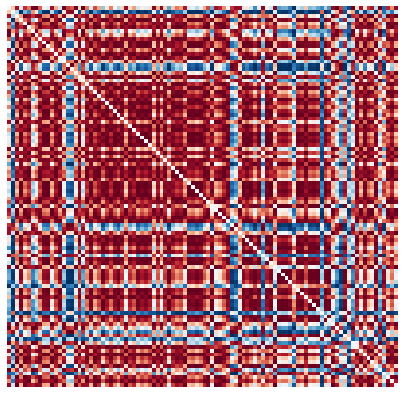

In [5]:
which_time = 500 # Which time point connectivity matrix to plot 
R = 100 # Number of Regions 

order = np.array([37,38,39,40,41,42,43,44,45,46,47,48,49,
                  89,90,91,92,93,94,95,96,97,98,99,
                  
                  33,34,35,36,
                  80,81,82,83,84,85,86,87,88,
                  
                  9,10,11,12,13,14,
                  58,59,60,61,62,63,64,65,
                  
                  30,31,32,
                  78,79,
                  
                  23,24,25,26,27,28,29,
                  73,74,75,76,77,
                  
                  15,16,17,18,19,20,21,22,
                  66,67,68,69,70,71,72,
                  
                  0,1,2,3,4,5,6,7,8,
                  50,51,52,53,54,55,56,57
                 ])

idx = np.where(np.tril(np.ones((R, R)), k=-1))
patt = np.zeros((R, R))
Patterns = loadmat(os.path.join(res_dir, 'Rest_Patterns.mat'))['Patterns']
patt[idx] = Patterns[:,which_time]
patt = patt + patt.T 

patt_ord = patt[order,:][:,order]

# Plotting and Saving the pattern 
f, ax = plt.subplots(1,1, figsize=(7,7))
sns.heatmap(patt_ord, cmap='RdBu_r', ax=ax, cbar=False, vmin=-1, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
#f.savefig(res_dir+'/time_'+str(which_time)+'_pattern.png', dpi=300)

In [26]:
a = (idx[0])

In [22]:
patt[idx] = Patterns[:,500]
patt

array([[ 0.        ,  0.85186208,  0.28689448, ...,  0.3059211 ,
         0.92219451,  0.75735764],
       [ 0.85186208,  0.        ,  0.74614272, ..., -0.2380526 ,
         0.58302834,  0.30314478],
       [ 0.28689448,  0.74614272,  0.        , ..., -0.82426741,
        -0.10589673, -0.40826788],
       ...,
       [ 0.3059211 , -0.2380526 , -0.82426741, ...,  0.        ,
         0.65030426,  0.85338511],
       [ 0.92219451,  0.58302834, -0.10589673, ...,  0.65030426,
         0.        ,  0.9509635 ],
       [ 0.75735764,  0.30314478, -0.40826788, ...,  0.85338511,
         0.9509635 ,  0.        ]])

## K-Means clustering of the connectivity patterns

### K-means fitting 
For the K-means clustering the following codes have been used. However because the result of this algorithm is different at each run, we put our resulted model in the dataset and the rest of the codes will be executed based on our fitted model. 

In [29]:
n_states = 4 # Number of clusters 

# Reading connectivity matrices file 
patterns = loadmat(os.path.join(res_dir, 'Rest_Patterns.mat'))['Patterns'].T

# Fitting model to the data 
kmeans = KMeans(n_clusters=n_states, n_init=500, max_iter=200).fit(patterns)

# Saving the results 
pickle.dump(kmeans, open(os.path.join(res_dir, 'kmeans_model.sav'), 'wb'))

### Extracting Centroids and Labels

In [30]:

R = 100 # Number of Regions 
idx = np.where(np.tril(np.ones((R, R)), k=-1))

patt1 = np.zeros((R, R))
patt2 = np.zeros((R, R))
patt3 = np.zeros((R, R))
patt4 = np.zeros((R, R))

patt1[idx] = kmeans.cluster_centers_[0,:]
patt2[idx] = kmeans.cluster_centers_[1,:]
patt3[idx] = kmeans.cluster_centers_[2,:]
patt4[idx] = kmeans.cluster_centers_[3,:]

patt1 = patt1+patt1.T
patt2 = patt2+patt2.T
patt3 = patt3+patt3.T
patt4 = patt4+patt4.T

# For Compatibility with previous publications I changed first and last patterns
cent4 = patt1[order,:][:,order]
cent2 = patt2[order,:][:,order]
cent3 = patt3[order,:][:,order]
cent1 = patt4[order,:][:,order]

labels = kmeans.labels_
for i in range(len(labels)):
    if labels[i] == 0: 
        labels[i] = 3 
    elif labels[i] == 3: 
        labels[i] = 0
        
# Saving the results 
kmeans_dict = {
    'cent1':cent1,
    'cent2':cent2,
    'cent3':cent3,
    'cent4':cent4,
    'labels':labels
}

kmeans_dict_orig = {
    'cent1':patt4,
    'cent2':patt2,
    'cent3':patt3,
    'cent4':patt1,
    'labels':labels
}
savemat(os.path.join(res_dir, 'kmeans_results.mat'), kmeans_dict)
savemat(os.path.join(res_dir, 'kmeans_results_orig.mat'), kmeans_dict_orig)

In [31]:
def my_func(*argv):
    return len(argv)

my_func(5,6)

2

### Plotting Centroids

/Users/nicobruno/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator KMeans from version 0.22.1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


p-value
[1.52913672e-01 3.56371641e-01 2.28601370e-06 5.81873644e-02
 1.39765166e-05 1.05549655e-05]
 
t-values
[[        nan -1.56139602  0.93465215 -6.23327124]
 [ 1.56139602         nan  2.14711208 -5.27450228]
 [-0.93465215 -2.14711208         nan -5.50055168]
 [ 6.23327124  5.27450228  5.50055168         nan]]
 
Effect Sizes
[[        nan -0.26023267  0.15577536 -1.03887854]
 [ 0.26023267         nan  0.35785201 -0.87908371]
 [-0.15577536 -0.35785201         nan -0.91675861]
 [ 1.03887854  0.87908371  0.91675861         nan]]


/var/folders/3p/z_m37csj5cs4hp5x2z1hsfrc0000gq/T/ipykernel_56299/2974424567.py:180: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.tril(np.ones_like(pval, dtype=np.bool))


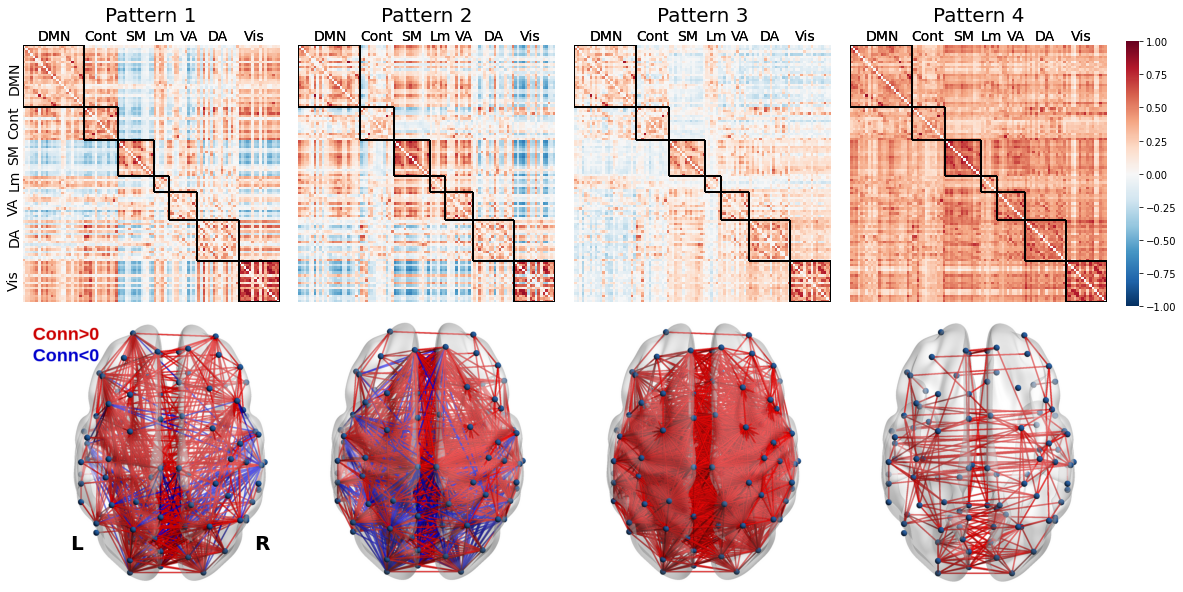

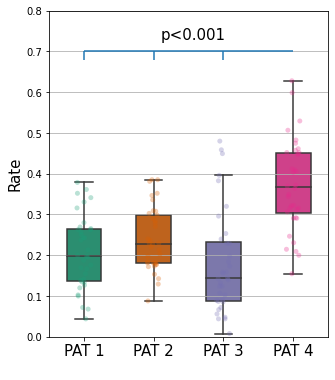

In [32]:
cent1 = loadmat(os.path.join(res_dir, 'kmeans_results.mat'))['cent1']
cent2 = loadmat(os.path.join(res_dir, 'kmeans_results.mat'))['cent2']
cent3 = loadmat(os.path.join(res_dir, 'kmeans_results.mat'))['cent3']
cent4 = loadmat(os.path.join(res_dir, 'kmeans_results.mat'))['cent4']
labels = loadmat(os.path.join(res_dir, 'kmeans_results.mat'))['labels'][0]

f, a = plt.subplots(2,5, figsize=(20,10), 
                    gridspec_kw={'height_ratios':[1, 1],
                                 'width_ratios' :[1,1,1,1,0.05], 
                                 'wspace': 0.09})

sns.heatmap(cent1, cmap='RdBu_r', ax=a[0,0], vmin=-1, vmax=1, square=True, cbar=False)
sns.heatmap(cent2, cmap='RdBu_r', ax=a[0,1], vmin=-1, vmax=1, square=True, cbar=False)
sns.heatmap(cent3, cmap='RdBu_r', ax=a[0,2], vmin=-1, vmax=1, square=True, cbar=False)
sns.heatmap(cent4, cmap='RdBu_r', ax=a[0,3], vmin=-1, vmax=1, square=True, cbar=True, cbar_ax=a[0,4])

a[0,0].set_xticks([])
a[0,0].set_yticks([])
a[0,0].set_title('Pattern 1', size=20, pad=24)
a[0,1].set_title('Pattern 2', size=20, pad=24)
a[0,2].set_title('Pattern 3', size=20, pad=24)
a[0,3].set_title('Pattern 4', size=20, pad=24)

plt.subplots_adjust(hspace = 0.05)

for i in range(4):
    a[0,i].hlines(0, 0, 24, color='k', linewidth=2)
    a[0,i].hlines(24, 0, 24, color='k', linewidth=2)
    a[0,i].vlines(0, 0, 24, color='k', linewidth=2)
    a[0,i].vlines(24, 0, 24, color='k', linewidth=2)
    a[0,i].text(6,-2,'DMN', size=14)
    a[0,i].text(6,-2,'DMN', size=14)

    a[0,i].hlines(37, 24, 37, color='k', linewidth=2)
    a[0,i].hlines(24, 24, 37, color='k', linewidth=2)
    a[0,i].vlines(37, 24, 37, color='k', linewidth=2)
    a[0,i].vlines(24, 24, 37, color='k', linewidth=2)
    a[0,i].text(24,-2,'Cont', size=14)
    a[0,i].text(24,-2,'Cont', size=14)

    a[0,i].hlines(51, 37, 51, color='k', linewidth=2)
    a[0,i].hlines(37, 37, 51, color='k', linewidth=2)
    a[0,i].vlines(51, 37, 51, color='k', linewidth=2)
    a[0,i].vlines(37, 37, 51, color='k', linewidth=2)
    a[0,i].text(40,-2,'SM', size=14)
    a[0,i].text(40,-2,'SM', size=14)

    a[0,i].hlines(57, 51, 57, color='k', linewidth=2)
    a[0,i].hlines(51, 51, 57, color='k', linewidth=2)
    a[0,i].vlines(57, 51, 57, color='k', linewidth=2)
    a[0,i].vlines(51, 51, 57, color='k', linewidth=2)
    a[0,i].text(51,-2,'Lm', size=14)
    a[0,i].text(51,-2,'Lm', size=14)

    a[0,i].hlines(68, 57, 68, color='k', linewidth=2)
    a[0,i].hlines(57, 57, 68, color='k', linewidth=2)
    a[0,i].vlines(68, 57, 68, color='k', linewidth=2)
    a[0,i].vlines(57, 57, 68, color='k', linewidth=2)
    a[0,i].text(61,-2,'VA', size=14)
    a[0,i].text(61,-2,'VA', size=14)

    a[0,i].hlines(84, 68, 84, color='k', linewidth=2)
    a[0,i].hlines(68, 68, 84, color='k', linewidth=2)
    a[0,i].vlines(84, 68, 84, color='k', linewidth=2)
    a[0,i].vlines(68, 68, 84, color='k', linewidth=2)
    a[0,i].text(72,-2,'DA', size=14)
    a[0,i].text(72,-2,'DA', size=14)

    a[0,i].hlines(100, 84, 100, color='k', linewidth=2)
    a[0,i].hlines(84, 84, 100, color='k', linewidth=2)
    a[0,i].vlines(100, 84, 100, color='k', linewidth=2)
    a[0,i].vlines(84, 84, 100, color='k', linewidth=2)
    a[0,i].text(86,-2,'Vis', size=14)
    a[0,i].text(86,-2,'Vis', size=14)

a[0,0].text(-6,18,'DMN', size=14, rotation=90)
a[0,0].text(-6,35,'Cont', size=14, rotation=90)
a[0,0].text(-6,45,'SM', size=14, rotation=90)
a[0,0].text(-6,55,'Lm', size=14, rotation=90)
a[0,0].text(-6,65,'VA', size=14, rotation=90)
a[0,0].text(-6,77,'DA', size=14, rotation=90)
a[0,0].text(-6,94,'Vis', size=14, rotation=90)

for i in range(1,4):
    a[0,i].set_yticks([])
    a[0,i].set_xticks([])

# Patterns Occurrence Rates 

kmeans = pickle.load(open(os.path.join(kmeans_dir, 'kmeans_model.sav'), 'rb'))
rate_df = pd.DataFrame({
    'subject':[0],
    'label':[0],
    'rate':[0]
})
subj_pointer = loadmat(os.path.join(res_dir, 'Rest_Patterns.mat'))['Subject_Pointer'][0]

for i in range(len(subjects)):
    idx = np.where(subj_pointer==i)
    L = kmeans.labels_[idx]
    for k in range(4): 
        if k ==0: 
            lab = 3
        elif k==3: 
            lab = 0 
        else: 
            lab = k
        tmp_df=({
            'subject':subjects[i],
            'label':lab,
            'rate':sum(L==k)/len(L)
            })
        rate_df = rate_df.append(tmp_df, ignore_index=True)
rate_df = rate_df.drop(0)

# Performing paired t-test analysis
reports = [0, 1, 2, 3] 
pval = np.zeros((4,4))
stat = np.zeros((4,4))
eff_size = np.zeros((4,4))
for i in range(len(reports)):
    for j in range(len(reports)):
        pval[i,j] = ttest_rel(rate_df[rate_df.label == reports[i]]['rate'], 
                              rate_df[rate_df.label == reports[j]]['rate']).pvalue
        stat[i,j] = ttest_rel(rate_df[rate_df.label == reports[i]]['rate'], 
                              rate_df[rate_df.label == reports[j]]['rate']).statistic
        eff_size[i,j] = stat[i,j]/np.sqrt(len(rate_df[rate_df.label == reports[i]]['rate']))


ff, aa = plt.subplots(1,1, figsize=(5,6))
sns.stripplot(x='label', y='rate', data=rate_df, ax=aa, alpha=0.3, palette='Dark2')
sns.boxplot(x='label', y='rate', data=rate_df, ax=aa,
            fliersize=0, width=0.5, palette='Dark2')
for i,artist in enumerate(aa.artists):
    col = artist.get_facecolor()
    artist.set_edgecolor(col)
    artist.set_facecolor('None')
    for j in range(i*6,i*6+6):
        line = aa.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)
aa.set_xticklabels(['PAT 1', 'PAT 2', 'PAT 3', 'PAT 4'], size=15)
aa.grid(True, axis='y')
aa.set_ylim([0,0.8])
aa.set_xlabel(' ')
aa.set_ylabel('Rate', size=15)

aa.hlines(0.7,0,3)
aa.vlines(0,0.68,0.7)
aa.vlines(1,0.68,0.7)
aa.vlines(2,0.68,0.7)
aa.text(1.1, 0.73, 'p<0.001', size=15)

# Adding Brain Connectivity Images (was made and saved using BrainNet in matlab)
import matplotlib.image as img  
for i in range(4):
    im = img.imread(kmeans_dir+'/rsz_cent'+str(i+1)+'.png')
    a[1,i].imshow(im)
    a[1,i].set_xticks([])
    a[1,i].set_yticks([])
    a[1,i].axis("off")
    
a[1,4].set_xticks([])
a[1,4].set_yticks([])
a[1,4].axis("off")
a[1,0].text(90,550,'L', fontsize=20, weight='bold')
a[1,0].text(530,550,'R', fontsize=20, weight='bold')

# Saving figure 
f.savefig(os.path.join(res_dir, 'Centroids.png'), dpi=300)
f.savefig(os.path.join(res_dir, 'Centroids.pdf'), dpi=300)
ff.savefig(os.path.join(res_dir, 'patF.png'), dpi=300)
ff.savefig(os.path.join(res_dir, 'patF.pdf'), dpi=300)

# Saving Occurence Rates 
rate_df.to_csv(os.path.join(res_dir, 'Patt_Occ_Rate.csv'))

print('p-value')
mask = np.tril(np.ones_like(pval, dtype=np.bool))
pval_cor = fdrcorrection(pval[~mask])
print(pval_cor[1])
print(' ')
print('t-values')
print(stat)
print(' ')
print('Effect Sizes')
print(eff_size)

### Patterns statistics

In [33]:
from scipy.stats import iqr
pattern = 0
print('median = ', np.median(rate_df[rate_df.label==pattern]['rate']))
print('IQR = ', iqr(rate_df[rate_df.label==pattern]['rate']))
print('min = ', np.min(rate_df[rate_df.label==pattern]['rate']))
print('max = ', np.max(rate_df[rate_df.label==pattern]['rate']))

median =  0.19866666666666666
IQR =  0.12566666666666665
min =  0.044
max =  0.37866666666666665


### Saving Connectivity Matrices together with Subjects IDs and Report Labels 
This result is also provided in the dataset. To save time, you can use the provided data in the rest of the codes. 

In [34]:
R = 100 # Number of Regions 
idx = np.where(np.tril(np.ones((R, R)), k=-1))
Patterns = np.zeros((R, R, 1))
States = []
Subjects = []
c=0 # Subject Counter 
do_filter = 1

pt_abs=np.zeros((len(idx[0]),1))
pt_sens=np.zeros((len(idx[0]),1))
pt_sdep=np.zeros((len(idx[0]),1))
pt_sind=np.zeros((len(idx[0]),1))

for sub in subjects: 
    sys.stdout.write('\r')
    sys.stdout.write("[{:{}}] {:.1f}%".format("="*c, len(subjects)-1, (100/(len(subjects)-1)*c)))
    
    sig_dir = img_dir + '/' + sub + '/Sig_file_' + sub + '.txt'
    trig_dir = img_dir + '/' + sub + '/log_results.mat'
    
    trig = loadmat(trig_dir)
    
    sig = np.loadtxt(sig_dir)
    sig = zscore(sig, axis=1)
    sigc = np.concatenate((np.fliplr(sig), sig, np.fliplr(sig)), axis=1)
    if do_filter:
        sigf = bp_filter(sigc, fmin=0.01, fmax=0.04, TR=2.04, order=2)
    else: 
        sigf = sigc
    sig = sigf[:,sig.shape[1]:sig.shape[1]*2]
    phi = np.angle(signal.hilbert(sig, axis=1))
    
    T = sig.shape[1]
    R = sig.shape[0]
    for label in ['Abs', 'SInd', 'SDep', 'Sens']:
        trig_idx = np.where(trig[label][0])
        for t in trig_idx[0]: 
            patt = np.zeros((R, R))
            for i in range(R): 
                for j in range(R): 
                    patt[i, j] = np.cos(adif(phi[i,t], phi[j,t]))
            for i in range(R):
                patt[i,i] = 0
                
            Patterns = np.concatenate((Patterns, patt.reshape((R,R,1))), axis=2)
            States.append(label)
            Subjects.append(sub)
    sys.stdout.flush()
    sleep(0.1)
    c=c+1
Patterns = Patterns[:,:,1:]

res_to_save = {'patterns':Patterns, 
               'states':States,
               'subj_ID':Subjects
              }
savemat(os.path.join(res_dir, 'Patt_State_Subj.mat'), res_to_save)

[===================================] 100.0%

## Pattern Occurence Rate Analysis

/Users/nicobruno/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator KMeans from version 0.22.1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/nicobruno/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3775: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try stripplot
  warnings.warn(msg, UserWarning)
/var/folders/3p/z_m37csj5cs4hp5x2z1hsfrc0000gq/T/ipykernel_56299/4050202160.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more deta

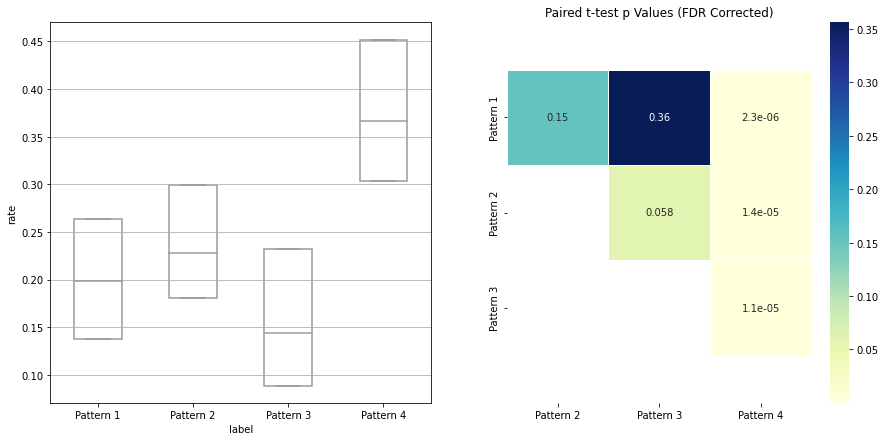

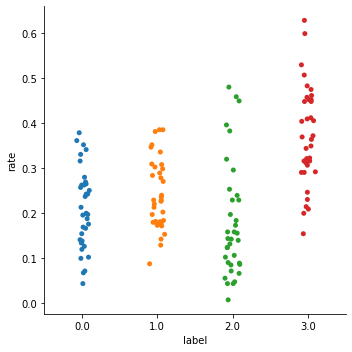

In [35]:
kmeans = pickle.load(open(os.path.join(kmeans_dir, 'kmeans_model.sav'), 'rb'))
subj_pointer = loadmat(os.path.join(res_dir, 'Rest_Patterns.mat'))['Subject_Pointer'][0]

rate_df = pd.DataFrame({
    'subject':[0],
    'label':[0],
    'rate':[0]
})

for i in range(len(subjects)):
    idx = np.where(subj_pointer==i)
    L = kmeans.labels_[idx]
    for k in range(4): 
        if k ==0: 
            lab = 3
        elif k==3: 
            lab = 0 
        else: 
            lab = k
        tmp_df=({
            'subject':i,
            'label':lab,
            'rate':sum(L==k)/len(L)
            })
        rate_df = rate_df.append(tmp_df, ignore_index=True)
rate_df = rate_df.drop(0)

f, a = plt.subplots(1,2, figsize=(15,7))
sns.catplot(x='label', y='rate', data=rate_df, ax=a[0])
sns.boxplot(x='label', y='rate', data=rate_df, ax=a[0],
            whis=0, showfliers=False, color='white', width=0.5)
a[0].set_xticklabels(['Pattern 1', 'Pattern 2', 'Pattern 3', 'Pattern 4'])
a[0].grid(True, axis='y')

patts= np.array(range(4))
pval = np.zeros((4,4))
for i in range(len(patts)):
    for j in range(len(patts)):
        pval[i,j] = ttest_rel(rate_df[rate_df.label == i]['rate'], rate_df[rate_df.label == j]['rate']).pvalue
        
mask = np.tril(np.ones_like(pval, dtype=np.bool))
pval_cor = fdrcorrection(pval[~mask])
pval_tmp = np.zeros((3,3))
mask2 = [[True, True, True], [False, True, True], [False, False, True]]
pval_tmp[np.where(mask2)] = pval_cor[1]
pval_tmp = pval_tmp 
mask = np.array([[ False, False, False],
                 [ True,  False, False],
                 [ True,  True, False]])
sns.heatmap(pval_tmp, cmap="YlGnBu", annot=True, 
            xticklabels=['Pattern 2', 'Pattern 3', 'Pattern 4'], yticklabels=['Pattern 1', 'Pattern 2', 'Pattern 3'], 
            ax=a[1], linewidths=.5, linecolor='white', mask=mask)
bottom, top = a[1].get_ylim()
a[1].set_ylim(bottom + 0.5, top - 0.5)
a[1].set_title('Paired t-test p Values (FDR Corrected)')
f.savefig(os.path.join(res_dir, 'Patt_Rate.png'), dpi=300)